# Final Project: Air Pollution Forecast using a Random Forest Regressor
## with PySpark on an EMR Cluster
### by Rodrigo Salazar



Note: 

This Jupyter notebook is meant to be run on an EMR cluste, using a Pyspark kernel.



Data: 

-[AWS OpenData - OpenAQ](https://registry.opendata.aws/openaq/)

-[OpenAQ Portal](https://explore.openaq.org/)

-[OpenAQ Documentation](https://docs.openaq.org/docs/accessing-openaq-archive-data#bucket-structure)


# Set up

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1685142953653_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6c/10/a7d0fa5baea8fe7b50f448ab742f26f52b80bfca85ac2be9d35cdd9a3246/pyparsing-3.0.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached htt

In [3]:
# Libraries we'll need
from pyspark.sql.functions import col, when
from pyspark.sql.functions import unix_timestamp
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Define the list of countries and years
countries = ['mx'] #'gr'#'mx'
years = ['2023'] #2023
month = ['03', '04', '05'] #2023

# Create the file path pattern with the countries and years
file_path = "s3://openaq-data-archive/records/csv.gz/provider=purpleair/country={{{}}}/locationid=*/year={{{}}}/month={{{}}}/*.csv.gz"

# Format the file path with the list of countries and years
formatted_path = file_path.format(','.join(countries), ','.join(years),  ','.join(month))

# Read data into a DataFrame with header option
data = spark.read.csv(formatted_path, header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Data exploration

Now that we have our data loaded in a DataFrame, let's take a look at its structure and contents. 

In [5]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 9
Total Rows: 18983022
root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

All the data are string, so we have to transform some of them, like 'datetime', 'value', 'lat' and 'lon'. Also, I have to ccreate a column 'category' that classifies the pm5 values into air quality categories according to the health risk they represent.

In [6]:
# Convert 'value' column to numeric type
data = data.withColumn('value', data['value'].cast('float'))
data = data.withColumn('lat', data['lat'].cast('float'))
data = data.withColumn('lon', data['lon'].cast('float'))
data = data.withColumn("timestamp", unix_timestamp(col("datetime"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Create a new column based on 'parameter' and classify PM2.5 values into categories
data = data.withColumn('category', when((col('parameter') == 'pm25') & (col('value') < 12), 'Good')
                                   .when((col('parameter') == 'pm25') & (col('value').between(12, 35)), 'Moderate')
                                   .when((col('parameter') == 'pm25') & (col('value') > 35), 'Unhealthy')
                                   .otherwise(None))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As we are only interested in the pm25 pollution parameter, we will proceed to filter the data.

In [7]:
# Filter the data to show only rows where 'category' is not null
filtered_data = data.filter(col('category').isNotNull())

# Filter out rows with values higher than 100 in the 'value' column
filtered_data = filtered_data.filter(filtered_data['value'] <= 1000)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
filtered_data[['value', 'parameter', 'units', 'lat', 'lon', 'timestamp', 'category']].show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+---------+-----+---------+----------+----------+---------+
|value|parameter|units|      lat|       lon| timestamp| category|
+-----+---------+-----+---------+----------+----------+---------+
| 27.1|     pm25|µg/m³|32.498634|-116.90548|1680332721| Moderate|
| 25.4|     pm25|µg/m³|32.498634|-116.90548|1680332839| Moderate|
| 25.5|     pm25|µg/m³|32.498634|-116.90548|1680332995| Moderate|
| 24.3|     pm25|µg/m³|32.498634|-116.90548|1680333084| Moderate|
| 33.5|     pm25|µg/m³|32.498634|-116.90548|1680333323| Moderate|
| 36.3|     pm25|µg/m³|32.498634|-116.90548|1680333444|Unhealthy|
| 28.9|     pm25|µg/m³|32.498634|-116.90548|1680333571| Moderate|
| 29.3|     pm25|µg/m³|32.498634|-116.90548|1680333807| Moderate|
| 27.2|     pm25|µg/m³|32.498634|-116.90548|1680333924| Moderate|
| 34.6|     pm25|µg/m³|32.498634|-116.90548|1680334050| Moderate|
| 37.1|     pm25|µg/m³|32.498634|-116.90548|1680334163|Unhealthy|
| 41.3|     pm25|µg/m³|32.498634|-116.90548|1680334284|Unhealthy|
| 38.5|   

Let's take a look at how our pm25 values are distributed

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

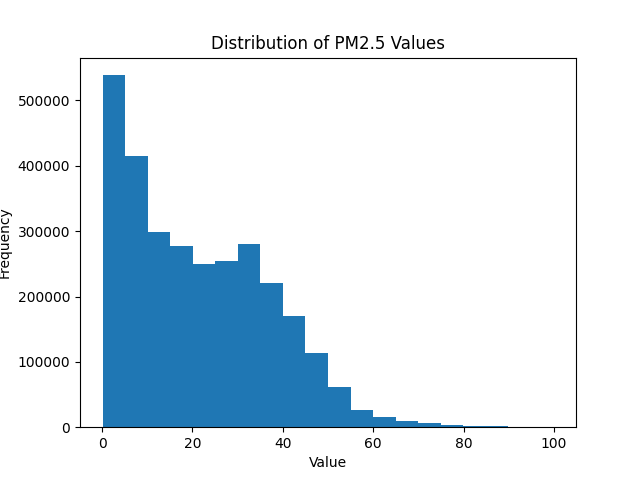

In [9]:
# Filter for 'pm25' in the 'parameter' column
filtered_data_pm25 = filtered_data.filter((filtered_data['parameter'] == 'pm25') & (filtered_data['value']>0) & (filtered_data['value']<100))

# Select the 'value' column
value_column = filtered_data_pm25.select('value')

# Convert the 'value' column to a Pandas Series for plotting
values = value_column.toPandas()['value']

# Plot the distribution of values
plt.close()
plt.hist(values, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5 Values')
%matplot plt


We can see that most of the data is concentrated in the moderated and good classification.

For our classification task we have to see if our data is balanced

In [10]:
# Take a look at how many good and bad reviews we have, respectively
cat = (filtered_data.groupBy('category')
     .count()
)
cat.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+
| category|  count|
+---------+-------+
| Moderate|1238029|
|     Good|1254152|
|Unhealthy| 636945|
+---------+-------+

As it is not, we will do some samplying.

In [11]:
fraction = 0.01
df_cat = cat.toPandas()
sum_counts = df_cat['count'].sum()
df_cat['proportion'] = df_cat['count'] / sum_counts
df_cat['inverse_prop'] = (1 / df_cat['proportion'])*fraction
df_cat['final_prop'] = df_cat['inverse_prop'] * (1/3)
fractions = df_cat[['category', 'final_prop']]
fractions = fractions.set_index('category')['final_prop'].to_dict()
sampled_data = filtered_data.sampleBy(col='category', fractions=fractions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
(sampled_data.groupBy('category')
     .count()
     .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
| category|count|
+---------+-----+
| Moderate|10280|
|     Good|10396|
|Unhealthy|10473|
+---------+-----+

The features we will be using are latitude, longitude and timestamp. Let's see in a graph if the location could be useful for our task.

In [13]:
# Calculate the mean of 'value' grouped by 'location_id'
mean_data = sampled_data.groupBy('location_id').agg(F.mean('value').alias('mean_value'))

# Recalculate the 'category' based on the mean values
mean_data = mean_data.withColumn('category', F.when(mean_data['mean_value'] < 12, 'Good').when((mean_data['mean_value'] >= 12) & (mean_data['mean_value'] <= 35), 'Moderate').otherwise('Unhealthy'))

# Join the mean_data with the original data to get the 'lat' and 'lon' columns
joined_data = mean_data.join(sampled_data[['lat','lon','location_id']], 'location_id', 'left').dropDuplicates(['location_id'])

# Convert the grouped DataFrame to Pandas for plotting
pandas_df = joined_data.toPandas()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

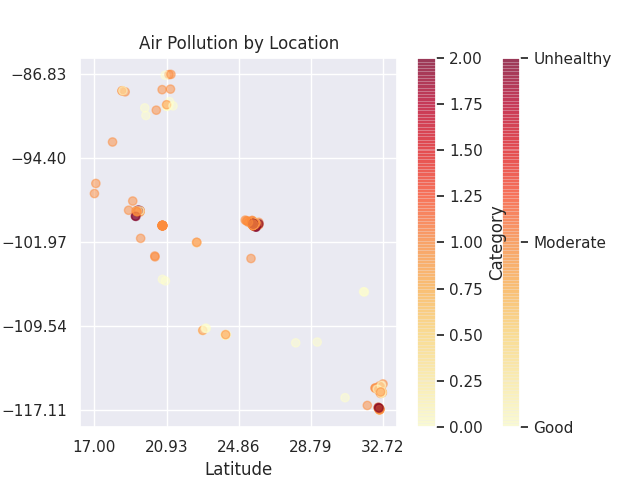

In [14]:
# Plot the data using 'lat' as x-axis, 'lon' as y-axis, and colors based on 'category'
plt.close()
sns.set(style='darkgrid')

# Convert 'category' column to numeric values
category_mapping = {'Good': 0, 'Moderate': 1, 'Unhealthy': 2}
pandas_df['category_num'] = pandas_df['category'].map(category_mapping)

# Plot the scatter plot
plt.scatter(pandas_df['lat'], pandas_df['lon'], alpha = 0.5, c=pandas_df['category_num'], cmap='YlOrRd')

# Add colorbar
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Good', 'Moderate', 'Unhealthy'])

# Set the desired number of ticks on the latitude and longitude axes
num_ticks = 5

# Get the min and max values of latitude and longitude
lat_min, lat_max = pandas_df['lat'].min(), pandas_df['lat'].max()
lon_min, lon_max = pandas_df['lon'].min(), pandas_df['lon'].max()

# Get the min and max values of latitude and longitude
lat_min, lat_max = pandas_df['lat'].min(), pandas_df['lat'].max()
lon_min, lon_max = pandas_df['lon'].min(), pandas_df['lon'].max()

# Calculate tick values based on the range of latitude and longitude
lat_ticks = np.linspace(lat_min, lat_max, num_ticks)
lon_ticks = np.linspace(lon_min, lon_max, num_ticks)

# Set the tick values for latitude and longitude axes
plt.xticks(lat_ticks)
plt.yticks(lon_ticks)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Air Pollution by Location')
plt.colorbar(label='Category')

%matplot plt


Upon analyzing the plot, we observe that the air pollution classification is not perfectly separated across all locations. This finding challenges any preconceived notions we might have had, considering that air pollutants can travel and disperse over long distances. However, it is important to note that there are specific regions where we observe strikingly similar trends in air pollution classification.

These regions with similar trends provide an intriguing opportunity for forecasting and prediction. The consistent patterns suggest that certain local factors or characteristics may influence air pollution levels, resulting in comparable classifications. By identifying and understanding these factors, we can potentially develop accurate forecasts for air pollution in these regions.

It is worth noting that while the overall data does not exhibit clear separation, the presence of localized patterns is promising. This implies that our model or predictive approach could be effective in these specific regions. By leveraging these localized trends, we can enhance our forecasting capabilities and provide targeted interventions and measures to mitigate air pollution. 

# The Model

We are going to use a Random Forest Regressor to make our forecast. In the Random Forest Regressor algorithm, multiple decision trees are trained on different subsets of the training data, and the final prediction is made by aggregating the predictions of all the individual trees. Each tree in the ensemble is built using a random subset of features and samples, which helps to reduce overfitting and improve the generalization ability of the model.

In [15]:
from pyspark.ml.feature import VectorAssembler

# Select the relevant columns for training
selected_columns = ['lat', 'lon','timestamp', 'value', 'category']
selected_data = sampled_data.select(*selected_columns)

# Create a VectorAssembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=['lat', 'lon','timestamp'], outputCol='features')
feature_data = assembler.transform(selected_data)

# Split the data into training and test sets
(train_data, test_data) = feature_data.randomSplit([0.7, 0.3])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
from pyspark.ml.regression import RandomForestRegressor

# Create and fit the random forest regressor
numTrees = 10  # Number of decision trees in the random forest
rf = RandomForestRegressor(numTrees=numTrees, labelCol='value', featuresCol='features')

model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show the predicted values and the corresponding features
predictions.select('value', 'prediction', 'features').show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+--------------------+
|value|        prediction|            features|
+-----+------------------+--------------------+
| 43.4|31.935450106477862|[25.5955562591552...|
| 40.0|31.935450106477862|[25.5955562591552...|
| 36.6|31.935450106477862|[25.5955562591552...|
| 42.4|31.935450106477862|[25.5955562591552...|
| 28.7|31.935450106477862|[25.5955562591552...|
| 35.3|31.935450106477862|[25.5955562591552...|
| 40.4|31.935450106477862|[25.5955562591552...|
| 34.7| 28.51706420051637|[25.7444057464599...|
| 43.4| 28.51706420051637|[25.7444057464599...|
| 54.3| 28.51706420051637|[25.7444057464599...|
| 47.3| 28.51706420051637|[25.7444057464599...|
| 29.3| 28.51706420051637|[25.7444057464599...|
| 21.8| 28.51706420051637|[25.7444057464599...|
|  7.3|23.368303358138405|[32.2879409790039...|
|  5.1|23.368303358138405|[32.2879409790039...|
| 19.2|23.368303358138405|[32.2879409790039...|
| 47.9| 28.97621911581164|[32.4471893310546...|
| 19.5| 28.97621911581164|[32.4471893310

In [17]:
# Calculate the 'category' based on the predictions
predictions = predictions.withColumn('pred_category', F.when(predictions['prediction'] < 12, 0.0).when((predictions['prediction'] >= 12) & (predictions['prediction'] <= 35), 1.0).otherwise(2.0))
predictions = predictions.withColumn('num_category', F.when(predictions['category'] == 'Good', 0.0).when(predictions['category'] == 'Moderate', 1.0).otherwise(2.0))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='num_category', predictionCol='pred_category', metricName='accuracy')

# Calculate the accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.4777275661717237

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

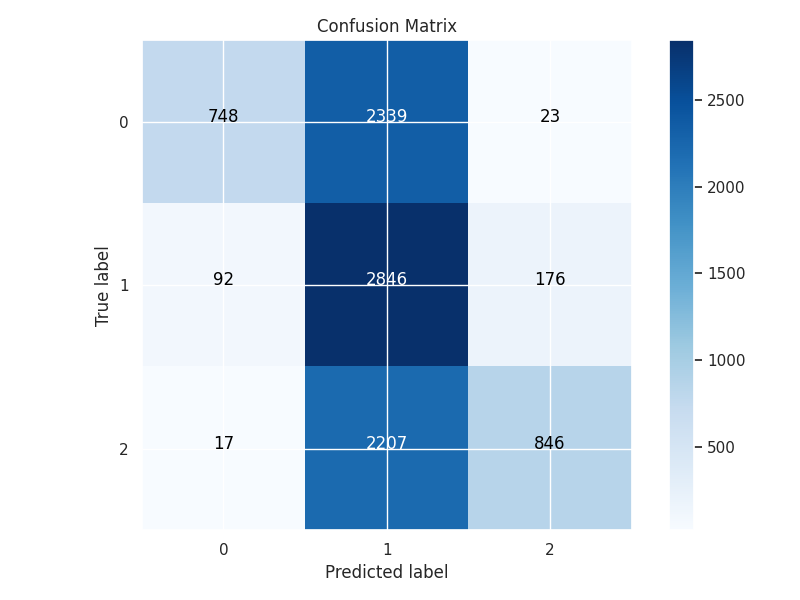

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Assuming you have a DataFrame `predictions` with columns 'label' and 'prediction'

# Convert DataFrame to RDD for MulticlassMetrics
predictionAndLabels = predictions.select('pred_category', 'num_category').rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix as a 2D numpy array
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix
plt.close()

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

# Set axis labels
tick_marks = np.arange(len(confusion_matrix))
plt.xticks(tick_marks, range(confusion_matrix.shape[1]))
plt.yticks(tick_marks, range(confusion_matrix.shape[0]))

# Set labels for each cell
thresh = confusion_matrix.max() / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, int(confusion_matrix[i, j]),
             horizontalalignment="center",
             color="white" if confusion_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
%matplot plt

Based on our analysis using random forest regression, we achieved an accuracy of 48%, which is significantly better than random guessing with a probability of 1/3. This indicates that our model has demonstrated some level of predictive power in forecasting climate factors. 

Considering the inherent complexity involved in climate forecasting, we can consider this accuracy level to be a favorable outcome. It suggests that our model has captured certain patterns and relationships within the data that contribute to accurate predictions.

Furthermore, when examining the Confusion Matrix, we observed interesting patterns. In the 'Good' and 'Unhealthy' classifications, our model made the second most popular predictions within their respective categories. Additionally, we noticed minimal instances of misclassifications in the farthest categories. These findings suggest that our model's performance goes beyond what can be solely assessed based on accuracy alone.

Overall, our results indicate that the random forest regression model has provided valuable insights and demonstrated promise in forecasting climate factors. Further refinement and exploration of the model could potentially enhance its predictive capabilities.